# Introduction to Text Processing
In order to feed text data to a deep learning model, we need to prepare the data through some common procedures. In this notebook, we will cover data cleaning and use the clean words to create a wordcloud. These processed words will also be used as input for our first RNN model.   

**Outline**  
- Load and inspect the dataset  
- Clean data and generate tokens
- Generate dataset tokens and a wordcloud  
- Use cleaned data to perform sentiment analysis using logistic regression 
  
**Estimated time:** 
 30 mins


In [1]:
### Change notebook directory, for Gadi environment only
import os
working_path = os.path.expandvars("/scratch/vp91/$USER/Introduction-to-NLP/")
os.chdir(working_path)
data_path = '/scratch/vp91/NLP-2024/data/'
model_path = '/scratch/vp91/NLP-2024/model/'

In [15]:
# local paths
# working_path = './'
# data_path = '../data/'
# model_path = '../model/'

# Load Modules

In [2]:
from string import digits, punctuation

# for text processing
import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string

#for inspecting data
import pandas as pd

# for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# store the data
import pickle
import wordcloud
from wordcloud import WordCloud
import sklearn

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/564/jt5911/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/564/jt5911/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/564/jt5911/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/564/jt5911/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Dataset

In [3]:
data = pd.read_json(data_path+'Sarcasm_Headlines_Dataset_v2.json',lines=True)
data

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...


# Inspect Data

First we check if there is any empty values in the dataset.

In [4]:
data.isna().value_counts()

is_sarcastic  headline  article_link
False         False     False           28619
dtype: int64

Then we can count the number of documents in each labeled category to see if this is a balanced dataset. If the dataset is unbalanced, the learning outcome will be biased since some label has more data to train.

/scratch/vp91/NLP-2024/nlp_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


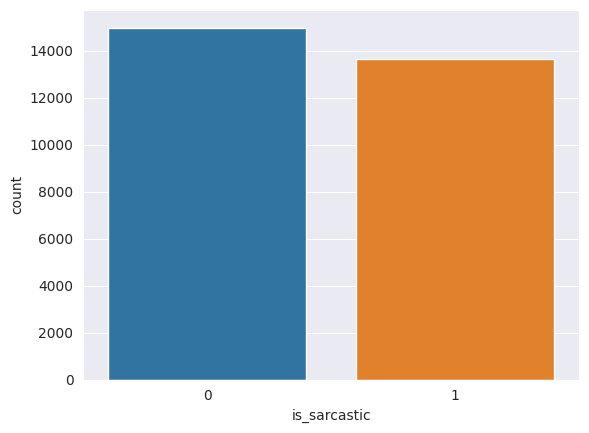

In [5]:
# count the data for different labels
sns.countplot(data.is_sarcastic)

Here I explored the number of words in each document for different category, and found that the non-sarcastic text is close to a normal distribution while the sarcastic ones are shorter and clustered together. Feel free to explore more in the dataset!

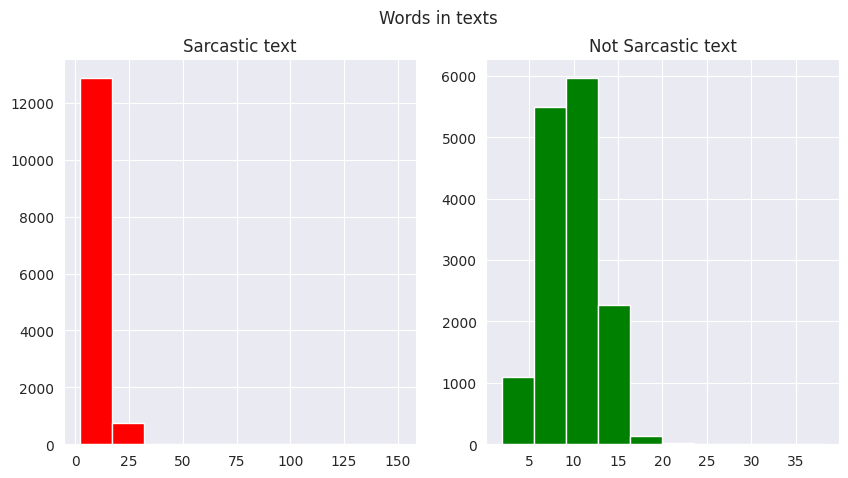

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = data[data['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len = data[data['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

# Prepare Data
## Data Cleaning  
There is a chance that the data you have are neatly printed for each record and all words are vital to your project goal, but more often is that you have some text from web pages with HTML tags still in them, or extra spaces, or the data quality is really inconsistent. 

In [7]:
headlines = [h for h in data.headline]
headlines[:20]

['thirtysomething scientists unveil doomsday clock of hair loss',
 'dem rep. totally nails why congress is falling short on gender, racial equality',
 'eat your veggies: 9 deliciously different recipes',
 'inclement weather prevents liar from getting to work',
 "mother comes pretty close to using word 'streaming' correctly",
 'my white inheritance',
 '5 ways to file your taxes with less stress',
 "richard branson's global-warming donation nearly as much as cost of failed balloon trips",
 'shadow government getting too large to meet in marriott conference room b',
 'lots of parents know this scenario',
 'this lesbian is considered a father in indiana (and an amazing one at that)',
 "amanda peet told her daughter sex is 'a special hug'",
 'what to know regarding current treatments for ebola',
 "chris christie suggests hillary clinton was to blame for boko haram's kidnapping of hundreds of schoolgirls",
 'ford develops new suv that runs purely on gasoline',
 'uber ceo travis kalanick step

In [8]:
def cleanText(text):
    text = text.lower().strip()
    # TODO remove the digits
    text = text.translate({ord(i): None for i in digits})
    # TODO remove the punctuations
    text = text.translate({ord(i): ' ' for i in punctuation})
    # text = ''.join(text)
    return text

In [9]:
headlines = [cleanText(t) for t in headlines]
headlines[:20]

['thirtysomething scientists unveil doomsday clock of hair loss',
 'dem rep  totally nails why congress is falling short on gender  racial equality',
 'eat your veggies   deliciously different recipes',
 'inclement weather prevents liar from getting to work',
 'mother comes pretty close to using word  streaming  correctly',
 'my white inheritance',
 ' ways to file your taxes with less stress',
 'richard branson s global warming donation nearly as much as cost of failed balloon trips',
 'shadow government getting too large to meet in marriott conference room b',
 'lots of parents know this scenario',
 'this lesbian is considered a father in indiana  and an amazing one at that ',
 'amanda peet told her daughter sex is  a special hug ',
 'what to know regarding current treatments for ebola',
 'chris christie suggests hillary clinton was to blame for boko haram s kidnapping of hundreds of schoolgirls',
 'ford develops new suv that runs purely on gasoline',
 'uber ceo travis kalanick steppi

<div class="alert alert-block alert-warning">
<b>Task 1.</b>Write a function to:<br>
 1. remove extra spaces  <br>
 2. change all text to lowercase   <br>
 3. remove all digits  <br>
 4. remove punctuations  <br>
  
</div>  

Below are some common build-in string functions in python, which are good starting points if you don't usually handle string data.  

**String functions:**   
 
- `str.lower()`
Return a copy of the string with all the cased characters 4 converted to lowercase.  

- `str.replace(old, new[, count])`
Return a copy of the string with all occurrences of substring old replaced by new. If the optional argument count is given, only the first count occurrences are replaced.  

- `str.strip([chars])`
Return a copy of the string with the leading and trailing characters removed.  

- `str.isalnum()`
Return True if all characters in the string are alphanumeric and there is at least one character, False otherwise.  

- `str.isdigit()`
Return True if all characters in the string are digits and there is at least one character, False otherwise.  

- `string.punctuation`
String of ASCII characters which are considered punctuation characters in the C locale: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~.  

[Full Python String Methods Doc](https://docs.python.org/3.7/library/stdtypes.html#string-methods)  
  
  
**Regular Expressions:**
- Matching characters  
    `[]` They represent a set of characters you wish to match. For example, `[abc]` will match `'a'`, `'b'` or `'c'`.  It also accepts a range of characters, i.e. `[a-c]` is equivilent to `[abc]`.  

    `\w` This matches any alphanumeric character, which is equivalent to `[a-zA-Z0-9_]`.  
    
    `\d` This matches any decimal digit, which is equivalent to `[0-9]`.
    
    `\s` This matches any whitespace, which is equivalent to `[ \t\n\r\f\v]`.   
    
    It can also match the complementing set by uppercase `\W`, `\D`, `\S`, or adding `^` at the beginning of a class. For example, `\D` matches anything but decimal digits, and it is equivilant to `[^0-9]`.  

- Matching repetitions  
    `*` specifies that the character before it may appear 0 or more times.  
    
    `+` specifies that the character before it appears at least 1 time.  
    
    `?` matches 0 or 1 time occurrence.  
    
    `{m,n}` matches at least m occurrence and at most n occurrence.  
- Functions   
    `re.sub(pattern, repl, string, count=0, flags=0)`  Returns the string obtained by replacing the leftmost non-overlapping occurrences of pattern in string by the replacement repl. If the pattern isn’t found, string is returned unchanged. repl can be a string or a function  


[Regular Expression HOWTO - a gentle explanation](https://docs.python.org/3/howto/regex.html#regex-howto)  



>   
>Think:  
> 1. Does the order of processing in your function matter? 
> 2. What would your function do if `<br />` become `</jats:p>` or other stuffs are inside?
> 3. What would your function return if there are `(...)` contents in the string?    
> 4. How clean should the data be?  


<div class="alert alert-block alert-danger">
<b>Challenge:</b> <br>
Write the `cleanAText(text)` function for this dirtier short paragraph and return a clean version of text.
</div>  

In [10]:
text = "     Many people thought that this is a good movie but I don't agree with them. At the beginning of the movie, a spaceship crushed on earth and some of the aliens escaped from the spaceship, then hey killed some people on the earth, but for no reason. Also, it is in a dark forest, I can't see anything on the screen, I can only hardly hear the sound.<br />             <br />After a few days, the predator came to the earth but no one had sent signals to him before that, he should not know what happened on the earth, so there is a contradiction. Finally, the predator found the headmaster (of the aliens) and killed it for no reason. He was not live on earth, t is none of his business about the things happened here. Lastly, the duration of the movie is only 90 minutes long, the summary is too short and it can't tell the reviewers about the story clearly.<br /><br />In conclusion, I don't think this is a good movie."

In [20]:
from bs4 import BeautifulSoup

def cleanAText(text):
    soup = BeautifulSoup(text)
    text = soup.get_text()
    
    text = text.replace("n't", 'nt')
    text = text.lower().strip()  # Replace capital letters with lower-case
    text = text.translate({ord(i): None for i in digits})  # Remove digits
    text = text.translate({ord(i): ' ' for i in punctuation})  # Remove punctuations

    return text

In [21]:
cleanAText(text)

'many people thought that this is a good movie but i dont agree with them  at the beginning of the movie  a spaceship crushed on earth and some of the aliens escaped from the spaceship  then hey killed some people on the earth  but for no reason  also  it is in a dark forest  i cant see anything on the screen  i can only hardly hear the sound  after a few days  the predator came to the earth but no one had sent signals to him before that  he should not know what happened on the earth  so there is a contradiction  finally  the predator found the headmaster  of the aliens  and killed it for no reason  he was not live on earth  t is none of his business about the things happened here  lastly  the duration of the movie is only  minutes long  the summary is too short and it cant tell the reviewers about the story clearly in conclusion  i dont think this is a good movie '

## Tokenisation, Remove Stopwords and Stemming  
There are a range of libraries that can achieve these steps. For this tutorial, we will use the good old `nltk`.   
We use the `word_tokenize` function from the package to get word tokens. `nltk` also has `sent_tokenize` that tokenize a paragraph into sentences.   
We also import the build-in stopwords from the package. The `nltk.corpus.stopwords` includes multiple language versions and we can have a look at the english version below.



In [22]:
word_tokenize('This is an tokenisation example.')

['This', 'is', 'an', 'tokenisation', 'example', '.']

In [23]:
sw = stopwords.words('english')
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [24]:
WordNetLemmatizer().lemmatize('works')

'work'

<div class="alert alert-block alert-warning">
<b>Task 2. Fill in nltk_token function </b>  <br>
1. Remove stopwords using nltk stopwords set <br>
2. Run the code to plot token frequency and wordcloud<br>
3. Examine your plot and wordcloud, improve the text cleaning functions<br>
</div>

In [26]:
def nltk_token(text):    
    # TODO tokenisation: get the list of tokens
    tokens = word_tokenize(text)

    # TODO remove stopwords
    stopwords_set = set(stopwords.words('english')) 

    tokens = [token for token in tokens if token not in stopwords_set]
    # lemmatization
    tokens = [WordNetLemmatizer().lemmatize(w) for w in tokens]
    
    return tokens

In [27]:
tokens = [nltk_token(t) for t in headlines]
tokens[:3]

[['thirtysomething',
  'scientist',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep',
  'totally',
  'nail',
  'congress',
  'falling',
  'short',
  'gender',
  'racial',
  'equality'],
 ['eat', 'veggie', 'deliciously', 'different', 'recipe']]

Now we put the `cleanText()` and `nltk_token` together to call it a `processText` function and return the cleaned headlines instead of tokens. Then we apply this function to our dataframe, headline column.

In [28]:
def processText(text):
    text = cleanText(text)
    tokens = nltk_token(text)
    text = ' '.join(tokens)
    return text

In [29]:
data_clean = data.copy()
data_clean.headline = data.headline.apply(processText)

In [30]:
data_clean.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientist unveil doomsday cloc...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep totally nail congress falling short ge...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat veggie deliciously different recipe,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar getting work,https://local.theonion.com/inclement-weather-p...
4,1,mother come pretty close using word streaming ...,https://www.theonion.com/mother-comes-pretty-c...


### Save tokens and cleaned data

In [31]:
with open(working_path+ 'tokens.pkl', 'wb') as f:
    pickle.dump(tokens, f)

In [32]:
with open(working_path+ 'data_clean.pkl', 'wb') as f:
    pickle.dump(data_clean, f)

### Plot Token Frequency

In [33]:
## total number of unique tokens in the collection
tokens = [token for l in tokens for token in l]
unique = set(tokens)
print("Number of unique tokens in the dataset: {}".format(len(unique)))

Number of unique tokens in the dataset: 22662


[('trump', 1834), ('new', 1684), ('man', 1526), ('woman', 966), ('year', 853), ('say', 710), ('report', 690), ('u', 659), ('get', 638), ('day', 613), ('one', 609), ('time', 591), ('american', 566), ('make', 547), ('area', 509), ('life', 490), ('like', 480), ('donald', 478), ('first', 472), ('old', 434)]


/scratch/vp91/NLP-2024/nlp_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


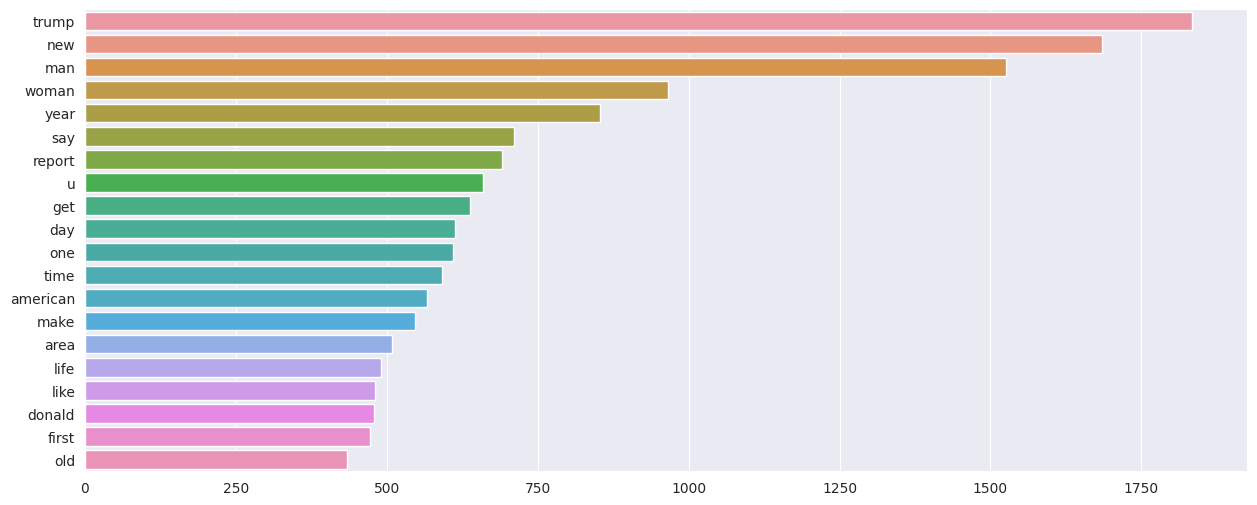

In [34]:
freq = nltk.FreqDist(tokens)

# print the top tokens
top_tokens = freq.most_common(20)
print(top_tokens)

# plot the distribution
token = [t[0] for t in top_tokens]
count = [t[1] for t in top_tokens]
plt.figure(figsize=(15, 6))  
sns.barplot(count, token)

### Plot Wordcloud

In [35]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(10, 8))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
# tokens list to string
str_tokens = ' '.join(tokens)

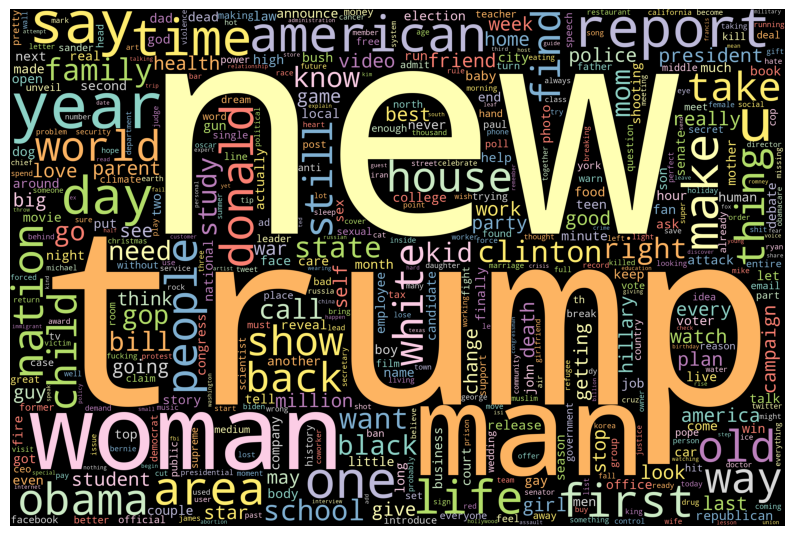

In [36]:
# improve word cloud with more stopwords removal
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
                      background_color='black',colormap='Set3', 
                      include_numbers=False,
                      collocations=False, max_words=500, 
                      ).generate(str_tokens)
# Plot
plot_cloud(wordcloud)

# Machine Learning Classification  
In this section we will demonstrate the basic implementation for classification tasks using `sklearn` model.
## Logistic regression

First, we use the `train_test_split` module for data preparation.

In [37]:
from sklearn.model_selection import train_test_split

y = data_clean['is_sarcastic'].values
data_clean.drop(['is_sarcastic'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data_clean, y, test_size=0.3, stratify=y)

print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (20033, 2) (20033,)
Test data: (8586, 2) (8586,)


In [38]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=10)

X_train_review_bow = vect.fit_transform(X_train['headline'])
X_test_review_bow = vect.transform(X_test['headline'])

print('X_train_review_bow shape: ', X_train_review_bow.shape)
print('X_test_review_bow shape: ', X_test_review_bow.shape)

X_train_review_bow shape:  (20033, 2862)
X_test_review_bow shape:  (8586, 2862)


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
clf.fit(X_train_review_bow, y_train)

y_pred = clf.predict(X_test_review_bow)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))

Test Accuracy:  0.7699743768926159


>Did the model converge? If not, try to modify it according to the warning message. [Hint](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)

Here we try the tf-idf representation and see if this has better results.

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10)

X_train_review_tfidf = vectorizer.fit_transform(X_train['headline'])
X_test_review_tfidf = vectorizer.transform(X_test['headline'])

print('X_train_review_tfidf shape: ', X_train_review_tfidf.shape)
print('X_test_review_tfidf shape: ', X_test_review_tfidf.shape)

X_train_review_tfidf shape:  (20033, 2862)
X_test_review_tfidf shape:  (8586, 2862)


In [41]:
clf = LogisticRegression()
clf.fit(X_train_review_tfidf, y_train)

y_pred = clf.predict(X_test_review_tfidf)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))

Test Accuracy:  0.7658979734451432


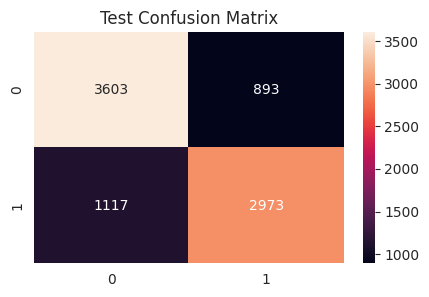

In [42]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

-----------------  

Next:  
You will proceed to [notebook 2](2-Glove-Embedding.ipynb) and build your RNN model for classification.